### Definición de funciones y carga de datos

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis

def kmeans_mahalanobis(X, k, max_iters=100):
    # Inicializar centroides aleatoriamente
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    # Calcular la matriz de covarianza inversa
    VI = np.linalg.inv(np.cov(X.T))
    
    for _ in range(max_iters):
        # Calcular distancias de Mahalanobis
        distances = np.array([[mahalanobis(x, c, VI) for c in centroids] for x in X])
        # Asignar etiquetas basadas en la distancia mínima
        labels = np.argmin(distances, axis=1)
        # Calcular nuevos centroides
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
        
        # Verificar convergencia
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    # Calcular las distancias de cada punto al centroide correspondiente
    min_distances = distances[np.arange(len(X)), labels]
    return centroids, labels, min_distances

def metodo_del_codo(X, max_k=10):
    wcss = []
    for k in range(1, max_k + 1):
        centroids, labels, min_distances = kmeans_mahalanobis(X, k)
        wcss.append(np.sum(min_distances ** 2))
    
    plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='-')
    plt.xlabel('Número de clústeres')
    plt.ylabel('WCSS')
    plt.title('Método del codo para encontrar el k óptimo')
    plt.show()

data_train=pd.read_excel('Datos_train.xlsx',index_col=0)
data_test = pd.read_excel('Datos_test.xlsx',index_col=0)  
etiq_verd_train=data_train[['Etiq']]
etiq_verd_test=data_test[['Etiq']]
data_train = data_train[['Temperatura','Consumo_Lavanderia', 'Consumo_Cocina', 
                         'Resto_Consumo', 'Habitantes']]
data_test = data_test[['Temperatura','Consumo_Lavanderia', 'Consumo_Cocina', 
                         'Resto_Consumo', 'Habitantes']]

print(data_train.head())
print(data_test.head())

data_train=np.array(data_train)
data_test=np.array(data_test)

     Temperatura  Consumo_Lavanderia  Consumo_Cocina  Resto_Consumo  \
518     0.395349            0.246374        0.331337       0.111447   
601     0.395349            0.198473        0.273396       0.490744   
602     0.139535            0.167176        0.252471       0.490744   
968     0.418605            0.317557        0.151627       0.576502   
325     0.651163            0.231298        0.182481       0.492255   

     Habitantes  
518      0.5625  
601      0.2500  
602      0.2500  
968      0.5625  
325      0.3750  
      Temperatura  Consumo_Lavanderia  Consumo_Cocina  Resto_Consumo  \
847      0.604651            0.203817        0.187748       0.219500   
298      0.232558            0.360687        0.181398       0.105780   
197      0.418605            0.243321        0.338336       0.170759   
1065     0.441860            0.244656        0.129014       0.223649   
881      0.697674            0.298664        0.159391       0.408765   

      Habitantes  
847       0.4

### Método del codo

<IPython.core.display.Javascript object>


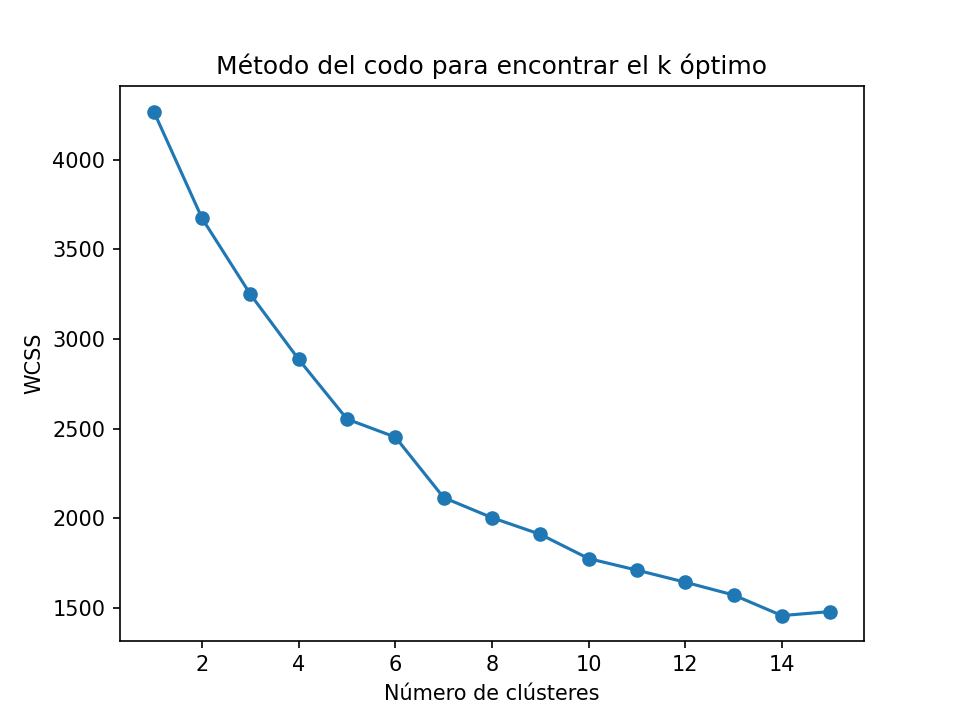

In [25]:
metodo_del_codo(data_train,15)

### Entrenamiento del modelo

<IPython.core.display.Javascript object>


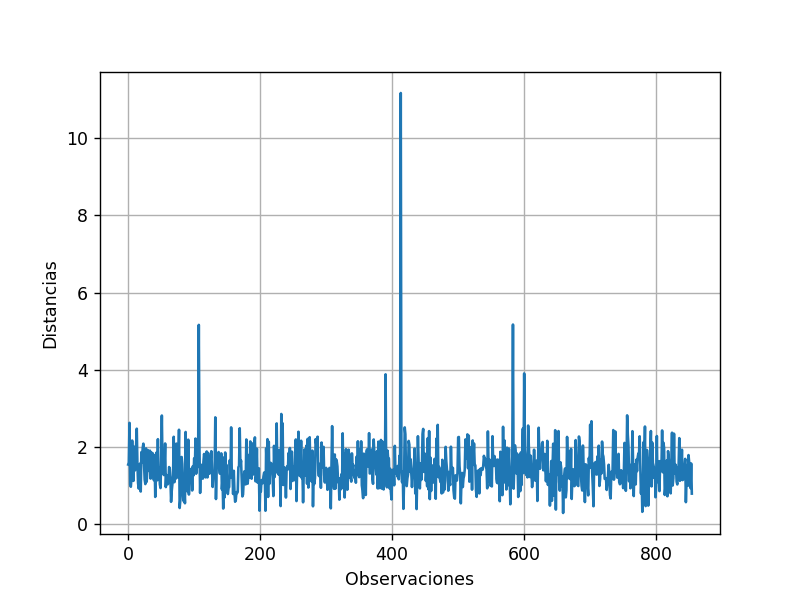

In [29]:
centroids, labels, distances=kmeans_mahalanobis(data_train, 7, max_iters=100)

plt.grid(True)
plt.plot(distances)
plt.xlabel('Observaciones')
plt.ylabel('Distancias')
plt.show()

### Análisis de TDA, TFA, Precisión y Umbral

<IPython.core.display.Javascript object>


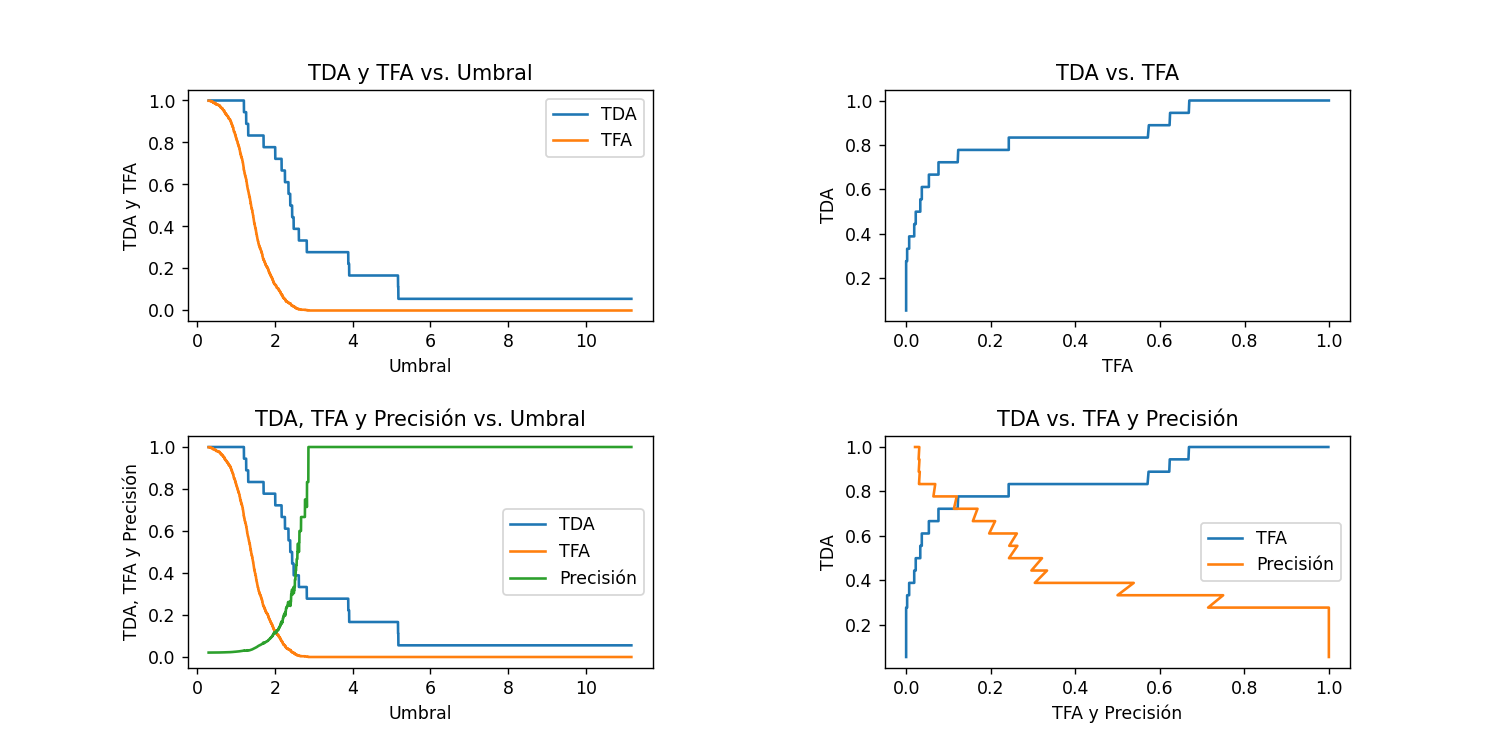

In [41]:
from sklearn.metrics import confusion_matrix

umbral = np.arange(np.min(distances), np.max(distances), 0.001)

tda=[]
tfa=[]
precis=[]

for i in range(len(umbral)):
    predicciones = np.where(distances > umbral[i], 1, 0)
    cm = confusion_matrix(etiq_verd_train, predicciones) 
    VP = cm[1, 1]
    FP = cm[0, 1]
    VN = cm[0, 0]
    FN = cm[1, 0]
    TDA= VP/(VP+FN) # Describe a la clase positiva (Clase Pos=VP+FN;Clase Neg=VN+FP)
    TFA=FP/(VN+FP)
    PREC=VP/(VP+FP) # Describe a las predicciones positivas correctas (PrediccPosit=VP+FP)
    tda.append(TDA)
    tfa.append(TFA)
    precis.append(PREC)
    
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
ax1, ax2, ax3, ax4 = axes.flatten()

ax1.plot(umbral, tda, label='TDA')
ax1.plot(umbral, tfa, label='TFA')
ax1.set_xlabel('Umbral')  
ax1.set_ylabel('TDA y TFA') 
ax1.set_title('TDA y TFA vs. Umbral')
ax1.legend()

ax2.plot(tfa, tda)
ax2.set_xlabel('TFA')  
ax2.set_ylabel('TDA')  
ax2.set_title('TDA vs. TFA')

ax3.plot(umbral, tda, label='TDA')
ax3.plot(umbral, tfa, label='TFA')
ax3.plot(umbral,precis,label='Precisión')
ax3.set_xlabel('Umbral')  
ax3.set_ylabel('TDA, TFA y Precisión') 
ax3.set_title('TDA, TFA y Precisión vs. Umbral')
ax3.legend()

ax4.plot(tfa,tda,label='TFA')
ax4.plot(precis, tda, label='Precisión')
ax4.set_xlabel('TFA y Precisión') 
ax4.set_ylabel('TDA') 
ax4.set_title('TDA vs. TFA y Precisión')
ax4.legend()

plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

### Selección manual de valores de TDA y TFA

<IPython.core.display.Javascript object>


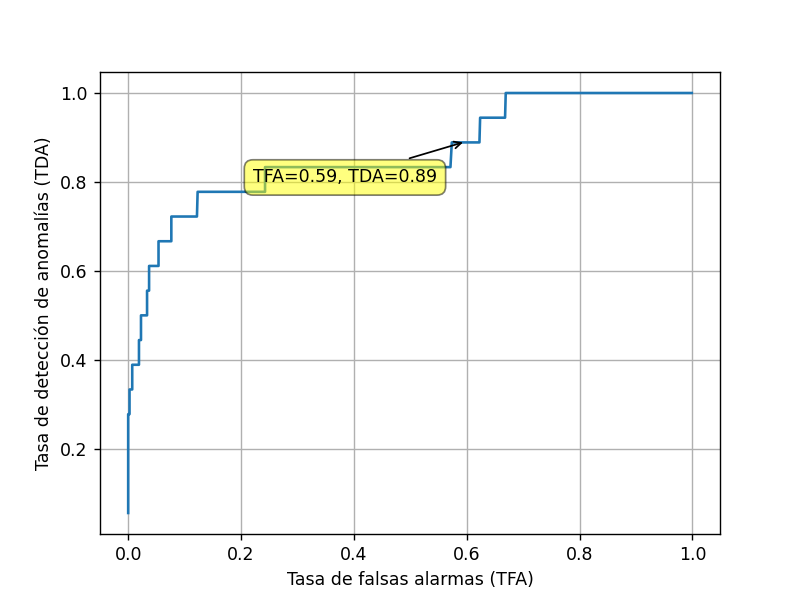

In [32]:
%matplotlib notebook
import mplcursors

fig, ax = plt.subplots()
ax.plot(tfa, tda)  
plt.xlabel('Tasa de falsas alarmas (TFA)')
plt.ylabel('Tasa de detección de anomalías (TDA)')
plt.grid(True)
# Habilitar la selección de puntos
cursor = mplcursors.cursor(ax, hover=True)
cursor.connect("add", lambda sel: sel.annotation.set_text(f'TFA={sel.target[0]:.2f}, TDA={sel.target[1]:.2f}'))
cursor.connect("add", lambda sel: sel.annotation.draggable(True))

plt.show()

### Cálculo del umbral, y resultados del entrenamiento (data_train)

In [35]:
from sklearn.metrics import classification_report

valor_tfa = input("Valor de TFA: ")
valor_tda = input("Valor de TDA: ")
valor_tfa=float(valor_tfa)
valor_tda=float(valor_tda)

def encontrar_indice_mas_cercano(tfa, tda, valor_tfa, valor_tda):
    distancias = []
    for i in range(len(tfa)):
        distancia = np.sqrt((tfa[i] - valor_tfa)**2 + (tda[i] - valor_tda)**2)
        distancias.append(distancia)
    indice_minimo = np.argmin(distancias)
    return indice_minimo

index_umb=encontrar_indice_mas_cercano(tfa, tda, valor_tfa, valor_tda)
umbral_dec=umbral[index_umb]
print ("Umbral para la decisión:", umbral_dec)
print("-----------------------------------------------------------------------")


anomalias = data_train[distances > umbral_dec]
print("Número de anomalías detectadas:", len(anomalias))
print("------------------------------------------------------------------------")

etiq_pred = np.where(distances > umbral_dec, 1, 0)
print(classification_report(etiq_verd_train, etiq_pred))
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_train, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("F1:", F1)

Valor de TFA: 0.6
Valor de TDA: 0.9
Umbral para la decisión: 1.2770641439903043
-----------------------------------------------------------------------
Número de anomalías detectadas: 519
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.40      0.57       837
           1       0.03      0.89      0.06        18

    accuracy                           0.41       855
   macro avg       0.51      0.64      0.31       855
weighted avg       0.97      0.41      0.56       855

------------------------------------------------------------------------
[[334 503]
 [  2  16]]
VP: 16
FP: 503
VN: 334
FN: 2
------------------------------------------------------------------------
TDA: 0.8888888888888888
TFA: 0.6009557945041816
Precision: 0.030828516377649325
F1: 0.0595903165735568


### Análisis de la calidad del clúster

In [20]:
# Cálculo del índice de Davies Bouldin
from sklearn.metrics import davies_bouldin_score
print("Índice de Davies-Bouldin:",davies_bouldin_score(data_train, labels))

# Cálculo del índice de Silueta
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(data_train, labels)
print("Índice de silueta:",silhouette_avg)

Índice de Davies-Bouldin: 1.5740401821350793
Índice de silueta: 0.17294506085842226


### Análisis y resultados en la validación (data_test)

In [40]:
# Detección de anomalías en los datos de validación
VI = np.linalg.inv(np.cov(data_train.T))
distances_v = np.array([min([mahalanobis(test, centroid, VI) for centroid in centroids]) for test in data_test])

anomalias = data_test[distances_v > umbral_dec]
print("Número de anomalías detectadas:", len(anomalias))
print("------------------------------------------------------------------------")

etiq_pred = np.where(distances_v > umbral_dec, 1, 0)
print(classification_report(etiq_verd_test, etiq_pred))
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_test, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("F1:", F1)

Número de anomalías detectadas: 119
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.47      0.64       204
           1       0.08      1.00      0.16        10

    accuracy                           0.49       214
   macro avg       0.54      0.73      0.40       214
weighted avg       0.96      0.49      0.61       214

------------------------------------------------------------------------
[[ 95 109]
 [  0  10]]
VP: 10
FP: 109
VN: 95
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.5343137254901961
Precision: 0.08403361344537816
F1: 0.1550387596899225


### Ajuste fino del umbral

In [49]:
umbral_fino = input("Valor del umbral:")
umbral_fino=float(umbral_fino)

print(" \n  \n ---------------- Datos de entrenamiento ----------------------------- \n ")
anomalias = data_train[distances > umbral_fino]
print("Número de anomalías detectadas:", len(anomalias))


etiq_pred = np.where(distances > umbral_fino, 1, 0)
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_train, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("F1:", F1)

print(" \n  \n ---------------- Datos de validación --------------------------- \n ")
anomalias = data_test[distances_v > umbral_fino]
print("Número de anomalías detectadas:", len(anomalias))


etiq_pred = np.where(distances_v > umbral_fino, 1, 0)
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_test, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("F1:", F1)


Valor del umbral:1.277
 
  
 ---------------- Datos de entrenamiento ----------------------------- 
 
Número de anomalías detectadas: 519
------------------------------------------------------------------------
[[334 503]
 [  2  16]]
VP: 16
FP: 503
VN: 334
FN: 2
------------------------------------------------------------------------
TDA: 0.8888888888888888
TFA: 0.6009557945041816
Precision: 0.030828516377649325
F1: 0.0595903165735568
 
  
 ---------------- Datos de validación --------------------------- 
 
Número de anomalías detectadas: 119
------------------------------------------------------------------------
[[ 95 109]
 [  0  10]]
VP: 10
FP: 109
VN: 95
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.5343137254901961
Precision: 0.08403361344537816
F1: 0.1550387596899225
